# Introduction

### Import relevant packages.

### Create functions that will be used to run sql queries, sql commands, and show a list of all the tables in the chinook database.

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

def show_tables():
    q = '''
    SELECT
        name,
        type
    FROM sqlite_master
    WHERE type IN ("table","view");
    '''
    return run_query(q)

show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


# Genre Sales in the USA

#### The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four. All four albums are by artists that don't have any tracks in the store right now - we have the artist names, and the genre of music they produce:

####            Regal	              -               Hip-Hop
####            Red Tone	       -               Punk
####            Meteor and the Girls	-   Pop
####            Slim Jim Bites	     -          Blues
            
#### The record label specializes in artists from the USA, and they have given Chinook some money to advertise the new albums in the USA, so we're interested in finding out which genres sell the best in the USA.

In [2]:
album_purchase = '''
    WITH FIRST AS
        (SELECT
              il.*,
              g.name Genre
        FROM invoice_line il
        INNER JOIN invoice i ON il.invoice_id = i.invoice_id
        INNER JOIN track t ON il.track_id = t.track_id
        INNER JOIN genre g ON t.genre_id = g.genre_id
        WHERE i.billing_country = "USA")
    SELECT
        Genre,
        SUM(quantity) Quantity,
        cast(count(f.track_id) AS FLOAT) / (
            SELECT COUNT(*) from FIRST
        )*100 percentage_sold
    FROM FIRST f
    GROUP BY 1
    ORDER BY 2 DESC
    Limit 10;
    '''

run_query(album_purchase)

,Genre,Quantity,percentage_sold
0,Rock,561,53.377735
1,Alternative & Punk,130,12.369172
2,Metal,124,11.798287
3,R&B/Soul,53,5.042816
4,Blues,36,3.425309
5,Alternative,35,3.330162
6,Latin,22,2.093245
7,Pop,22,2.093245
8,Hip Hop/Rap,20,1.902950
9,Jazz,14,1.332065


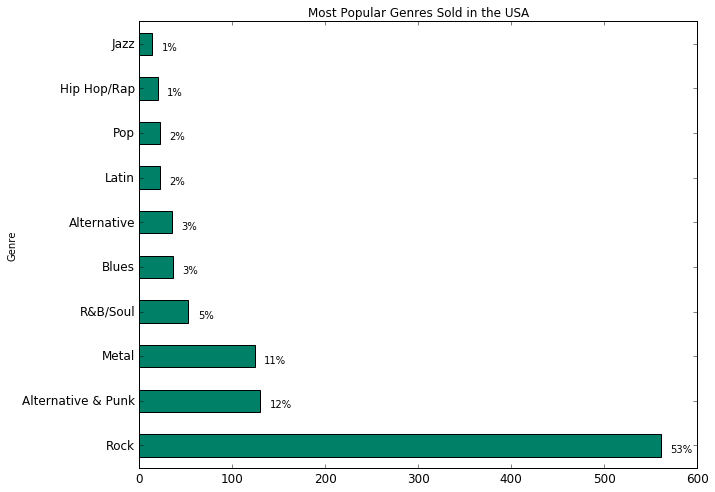

In [3]:
sqlq = run_query(album_purchase)

sqlq.plot.barh(x='Genre', y='Quantity',
        title=('Most Popular Genres Sold in the USA'), figsize=[10,8],
    fontsize=12,legend=False,xlim=(0, 600),
    colormap=plt.cm.summer)

for i, label in enumerate(list(sqlq.index)):
    score = sqlq.loc[label, "Quantity"]
    label = (sqlq.loc[label, "percentage_sold"]
            ).astype(int).astype(str) + "%"
    plt.annotate(str(label), (score + 10, i - 0.15))

plt.show()

### The top 3 best-selling genres in the USA are Rock, Alternative & Punk, and Metal.

### From the list of artists provided by the record label, the store should sell Red Tone, Slim Jim Bites, and Meteor and the Girls respective albums.

In [4]:
agent = '''
            SELECT 
                e.first_name || " " || e.last_name Agent_Name,
                e.hire_date,
                SUM(i.total) Total_Dollar_Sales
                FROM employee e
            INNER JOIN customer c ON e.employee_id = c.support_rep_id
            INNER JOIN invoice i ON c.customer_id = i.customer_id
            WHERE e.title = "Sales Support Agent"
            GROUP BY 1
            ;
            '''
run_query(agent)

,Agent_Name,hire_date,Total_Dollar_Sales
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


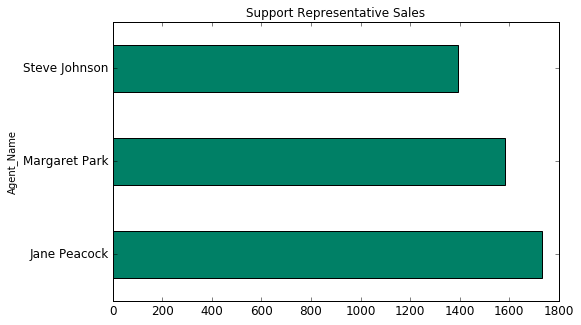

In [5]:
ssp = run_query(agent)
histo = ssp.plot.barh(x='Agent_Name', y='Total_Dollar_Sales',
        title=('Support Representative Sales'), figsize=[8,5],
    fontsize=12,legend=False,xlim=(0, 1800),
    colormap=plt.cm.summer)
plt.show(histo)

### The highest performing employee, Jane Peacock, sold about 20% more than Steve Johnson. Since Jane was hired 6 months before Steve, she was able to make more sales. So this analysis does not accurately reflect employee performance. 

### A better way to present the data would be to compare employee sales amount within a time range- from the hire date of the newest employee to the most recent date.